# Grafo del experimtento.
Primero, importamos las librerías

In [204]:
import math

import networkx as nx
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import choice as np_choice

Creamos la clase AntColony, que contiene el algoritmo ACO (Gracias a [INSERTAR NOMBRE, LINK])

In [205]:
class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(distances, 100, 20, 2000, 0.95, alpha=1, beta=2)
        """
        self.distances = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        distance_logs = []
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            distance_logs.append(all_time_shortest_path[1])
        return all_time_shortest_path, distance_logs

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # going back to where we started
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = (pheromone ** self.alpha) * ((1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

Leemos la tabla de datos, y la imprimimos

In [206]:
# Use pandas to read the data from the csv file.
df = pd.read_csv('nodos.csv')
# Create a dictionary with the data from the csv file.
#data = {'key': df['key'], 'x': df['x'], 'y': df['y'], 'cantidad': df['cantidad'], 'mineral': df['Mineral']}
data = {'key': df['key'], 'x': df['x'], 'y': df['y']}
df

,key,x,y,cantidad,Mineral
0,A,9083,6551,2,Au
1,B,9008,6504,2,Au
2,C,8950,6477,2,Au
3,D,8910,6415,2,Au
4,E,8881,6404,2,Au
5,F,8833,6407,3,Au
6,G,9123,6314,3,Fe
7,H,9162,6310,2,Fe
8,I,9084,6246,3,Fe
9,J,9146,6231,2,Fe


Creamos un grafo con las aristas, y pesos

In [207]:
G = nx.path_graph(0)


def distance(x1, y1, x2, y2):
    '''Calcula la distancia entre dos puntos'''
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


edges = {
    (i, j, distance(x1, y1, x2, y2))
    for i, x1, y1 in zip(data['key'], data['x'], data['y'])
    for j, x2, y2 in zip(data['key'], data['x'], data['y']) if i != j
}

G.add_weighted_edges_from(edges)  # Agrega los vertices a partir de un diccionario de tuplas con la forma (x,y,peso)
nodes = {
    i: (j, k)
    for i, j, k in zip(data['key'], data['x'], data['y'])
}


def to_linked_list(p):
    '''Convierte un conjunto de nodos en tuplas a una reperesentación en listas enlazadas'''
    return {i: sorted([(j, k) for l, j, k in p if i == l]) for i in data['key']}


edges2 = to_linked_list(edges)
#G.add_weighted_edges_from({(x, y, z) for x in edges2.keys() for y, z in edges2[x]}) # -> agrega a partir de una lista enlazada simple

Dibujamos el grafo

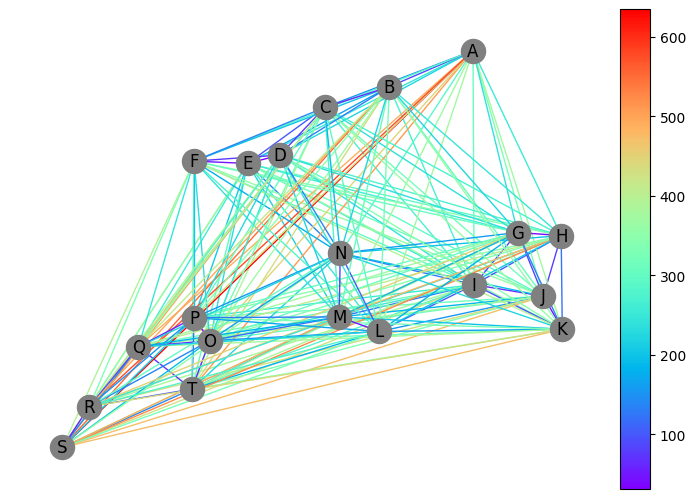

In [208]:
#Creamos el grafo
colormap = plt.cm.rainbow
nx.draw(G, nodes, edge_color=[G[u][v]['weight'] for (u, v) in G.edges()],
        edge_cmap=colormap, with_labels=True, node_color="gray")
# Creamos la barra de color
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
pesosw = list([G[u][v]['weight'] for (u, v) in G.edges()])
norm = mpl.colors.Normalize(vmin=min(pesosw), vmax=max(pesosw))
cb1 = mpl.colorbar.ColorbarBase(ax=ax_cb, cmap=colormap, norm=norm, orientation='vertical')
plt.gcf().add_axes(ax_cb)
#plt.savefig("original.png", transparent=True, dpi=150)
plt.show()

In [209]:
print("El arbol completo tiene " + str(len(G.edges)) + " aristas\n")


El arbol completo tiene 190 aristas



Ahora, creamos una matrix de pesos y la asignamos a una matrix tipo np (Para poder utilizar aco)

In [210]:
pesos = [(distance(x1, y1, x2, y2)) for i, x1, y1 in zip(data['key'], data['x'], data['y'])
         for j, x2, y2 in zip(data['key'], data['x'], data['y'])]
matrix = []
for i in range(20):
    matrix.append(pesos[i * 20:i * 20 + 20])
distances = np.array(matrix)
np.fill_diagonal(distances, np.inf)
#print(distances)

Ejecutamos aco, e imprimimos una tabla de pesos encontrados versus número de iteraciones

shortest_path: ([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 14), (14, 13), (13, 12), (12, 11), (11, 8), (8, 9), (9, 10), (10, 7), (7, 6), (6, 0)], 1826.874264874184)


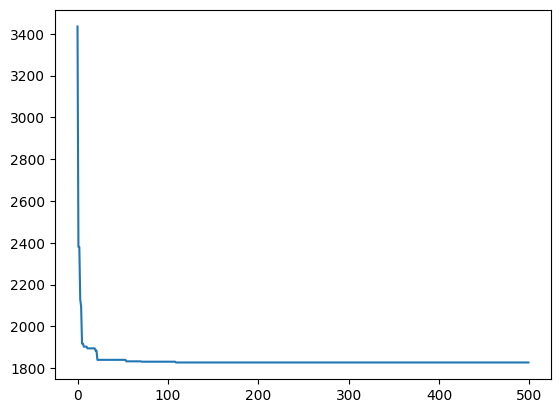

In [211]:
ant_colony = AntColony(distances, 50, 50, 500, 0.7, alpha=1, beta=1)
shortest_path, log = ant_colony.run()
print("shortest_path: {}".format(shortest_path))
plt.plot(log)
plt.show()

Imprimimos la lista de adyacencia

In [212]:
antPath, peso = shortest_path
edgelist = []
letras = "ABCDEFGHIJKLMNOPQRST"
for i in antPath:
    x, y = i
    edgelist.append((letras[x], letras[y]))
print(edgelist)

[('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E'), ('E', 'F'), ('F', 'P'), ('P', 'Q'), ('Q', 'R'), ('R', 'S'), ('S', 'T'), ('T', 'O'), ('O', 'N'), ('N', 'M'), ('M', 'L'), ('L', 'I'), ('I', 'J'), ('J', 'K'), ('K', 'H'), ('H', 'G'), ('G', 'A')]


Dibujamos el grafo

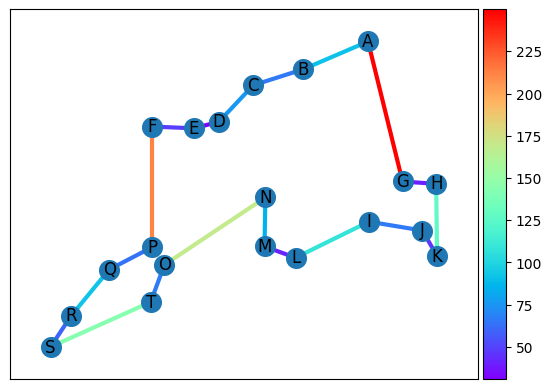

In [213]:
colormap = plt.cm.rainbow
H = G.copy
G.remove_edges_from([(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 250])
#nx.draw(G, nodes, edge_color=[G[u][v]['weight'] for (u, v) in G.edges()],
#        edge_cmap=colormap, with_labels=True, node_color="gray")
nx.draw_networkx(
    G,
    nodes,
    #with_labels=True,
    edgelist=edgelist,
    edge_color=[G[u][v]['weight'] for (u, v) in edgelist],
    edge_cmap=colormap,
    #edge_color="black",
    node_size=200,
    width=3,
)
# Creamos la barra de color
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
pesosw = list([G[u][v]['weight'] for (u, v) in G.edges()])
norm = mpl.colors.Normalize(vmin=min(pesosw), vmax=max(pesosw))
cb1 = mpl.colorbar.ColorbarBase(ax=ax_cb, cmap=colormap, norm=norm, orientation='vertical')
plt.gcf().add_axes(ax_cb)
#plt.savefig("original.png", transparent=True, dpi=150)
plt.show()